CELL 1: IMPORTS & GPU CHECK

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_fscore_support


DATASET_ROOT = r"C:\Projects\Thesis-Fall-25-26--G-606-main"
IMAGES_DIR = os.path.join(DATASET_ROOT, "Images")
LABELS_FILE = os.path.join(DATASET_ROOT, "Labels.csv")

IMG_SIZE = (224, 224)
BATCH_SIZE = 16  
LEARNING_RATE = 0.0001
EPOCHS = 15
SEED = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

Using Device: cuda


Cell 2: Dataset Class

In [2]:
class GlaucomaDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_name = self.annotations.iloc[index, 0]
        label_str = self.annotations.iloc[index, 2]
        img_path = os.path.join(self.root_dir, img_name)
        
        image = cv2.imread(img_path)
        if image is None:
            image = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = 1 if label_str == 'GON+' else 0
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)

Cell 3: Training Engine (With History Tracking)

In [3]:
def train_and_evaluate(model, train_loader, test_loader, epochs, model_name):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}
    
    print(f"\n--- Training {model_name} ---")
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0; correct = 0; total = 0
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        epoch_train_acc = 100 * correct / total
        epoch_train_loss = running_loss / len(train_loader)
        history['train_acc'].append(epoch_train_acc)
        history['train_loss'].append(epoch_train_loss)
        
        # Validation
        model.eval()
        val_correct = 0; val_total = 0; val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        epoch_val_acc = 100 * val_correct / val_total
        epoch_val_loss = val_loss / len(test_loader)
        history['val_acc'].append(epoch_val_acc)
        history['val_loss'].append(epoch_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {epoch_train_acc:.1f}% | Val Acc: {epoch_val_acc:.1f}%")
            
    return history

Cell 4: STAGE 1 - Baseline (Without Augmentation)

In [4]:
print("--- STAGE 1: RAW/BASELINE (No Augmentation) ---")

# 1. Basic Transform (Only Resize & Normalize)
transform_basic = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. Setup Data
dataset_basic = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform_basic)
indices = list(range(len(dataset_basic)))
split = int(np.floor(0.2 * len(dataset_basic)))
np.random.seed(SEED); np.random.shuffle(indices)

train_sampler = SubsetRandomSampler(indices[split:])
test_sampler = SubsetRandomSampler(indices[:split])

train_loader_basic = DataLoader(dataset_basic, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader_basic = DataLoader(dataset_basic, batch_size=BATCH_SIZE, sampler=test_sampler)

# 3. Load VGG16 (Pre-trained)
model_vgg_basic = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
# Freeze early layers to save memory/time
for param in model_vgg_basic.features.parameters():
    param.requires_grad = False
# Change last layer for 2 classes
model_vgg_basic.classifier[6] = nn.Linear(4096, 2)

# 4. Train Baseline
history_basic = train_and_evaluate(model_vgg_basic, train_loader_basic, test_loader_basic, EPOCHS, "VGG16 Baseline")

--- STAGE 1: RAW/BASELINE (No Augmentation) ---

--- Training VGG16 Baseline ---
Epoch 1/15 | Train Acc: 87.6% | Val Acc: 92.6%
Epoch 2/15 | Train Acc: 96.2% | Val Acc: 93.3%
Epoch 3/15 | Train Acc: 98.0% | Val Acc: 92.6%
Epoch 4/15 | Train Acc: 98.8% | Val Acc: 95.3%
Epoch 5/15 | Train Acc: 98.5% | Val Acc: 94.6%
Epoch 6/15 | Train Acc: 99.2% | Val Acc: 92.6%
Epoch 7/15 | Train Acc: 99.7% | Val Acc: 94.0%
Epoch 8/15 | Train Acc: 99.8% | Val Acc: 94.0%
Epoch 9/15 | Train Acc: 100.0% | Val Acc: 96.0%
Epoch 10/15 | Train Acc: 99.8% | Val Acc: 96.6%
Epoch 11/15 | Train Acc: 98.3% | Val Acc: 92.6%
Epoch 12/15 | Train Acc: 98.2% | Val Acc: 96.0%
Epoch 13/15 | Train Acc: 98.0% | Val Acc: 96.0%
Epoch 14/15 | Train Acc: 99.3% | Val Acc: 96.6%
Epoch 15/15 | Train Acc: 99.8% | Val Acc: 96.0%


Cell 5: STAGE 2 - Augmented (With Augmentation)

In [5]:
print("\n--- STAGE 2: AUGMENTED (With Transformations) ---")

# 1. Augmented Transform
transform_aug = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. Setup Data
dataset_aug = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform_aug)

# Use SAME split indices for fair comparison
train_loader_aug = DataLoader(dataset_aug, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader_aug = DataLoader(dataset_aug, batch_size=BATCH_SIZE, sampler=test_sampler)

# 3. Load Fresh VGG16
model_vgg_aug = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
for param in model_vgg_aug.features.parameters():
    param.requires_grad = False
model_vgg_aug.classifier[6] = nn.Linear(4096, 2)

# 4. Train Augmented Model
history_aug = train_and_evaluate(model_vgg_aug, train_loader_aug, test_loader_aug, EPOCHS, "VGG16 Augmented")


--- STAGE 2: AUGMENTED (With Transformations) ---

--- Training VGG16 Augmented ---
Epoch 1/15 | Train Acc: 87.1% | Val Acc: 96.6%
Epoch 2/15 | Train Acc: 95.3% | Val Acc: 93.3%
Epoch 3/15 | Train Acc: 95.8% | Val Acc: 95.3%
Epoch 4/15 | Train Acc: 95.8% | Val Acc: 96.6%
Epoch 5/15 | Train Acc: 96.7% | Val Acc: 94.6%
Epoch 6/15 | Train Acc: 97.3% | Val Acc: 94.0%
Epoch 7/15 | Train Acc: 95.8% | Val Acc: 94.6%
Epoch 8/15 | Train Acc: 97.3% | Val Acc: 95.3%
Epoch 9/15 | Train Acc: 96.7% | Val Acc: 93.3%
Epoch 10/15 | Train Acc: 96.3% | Val Acc: 93.3%
Epoch 11/15 | Train Acc: 98.3% | Val Acc: 93.3%
Epoch 12/15 | Train Acc: 97.5% | Val Acc: 95.3%
Epoch 13/15 | Train Acc: 96.8% | Val Acc: 95.3%
Epoch 14/15 | Train Acc: 95.7% | Val Acc: 94.6%
Epoch 15/15 | Train Acc: 98.5% | Val Acc: 95.3%


Cell 6: Comparison & Visualization

Generating Final VGG16 Report...


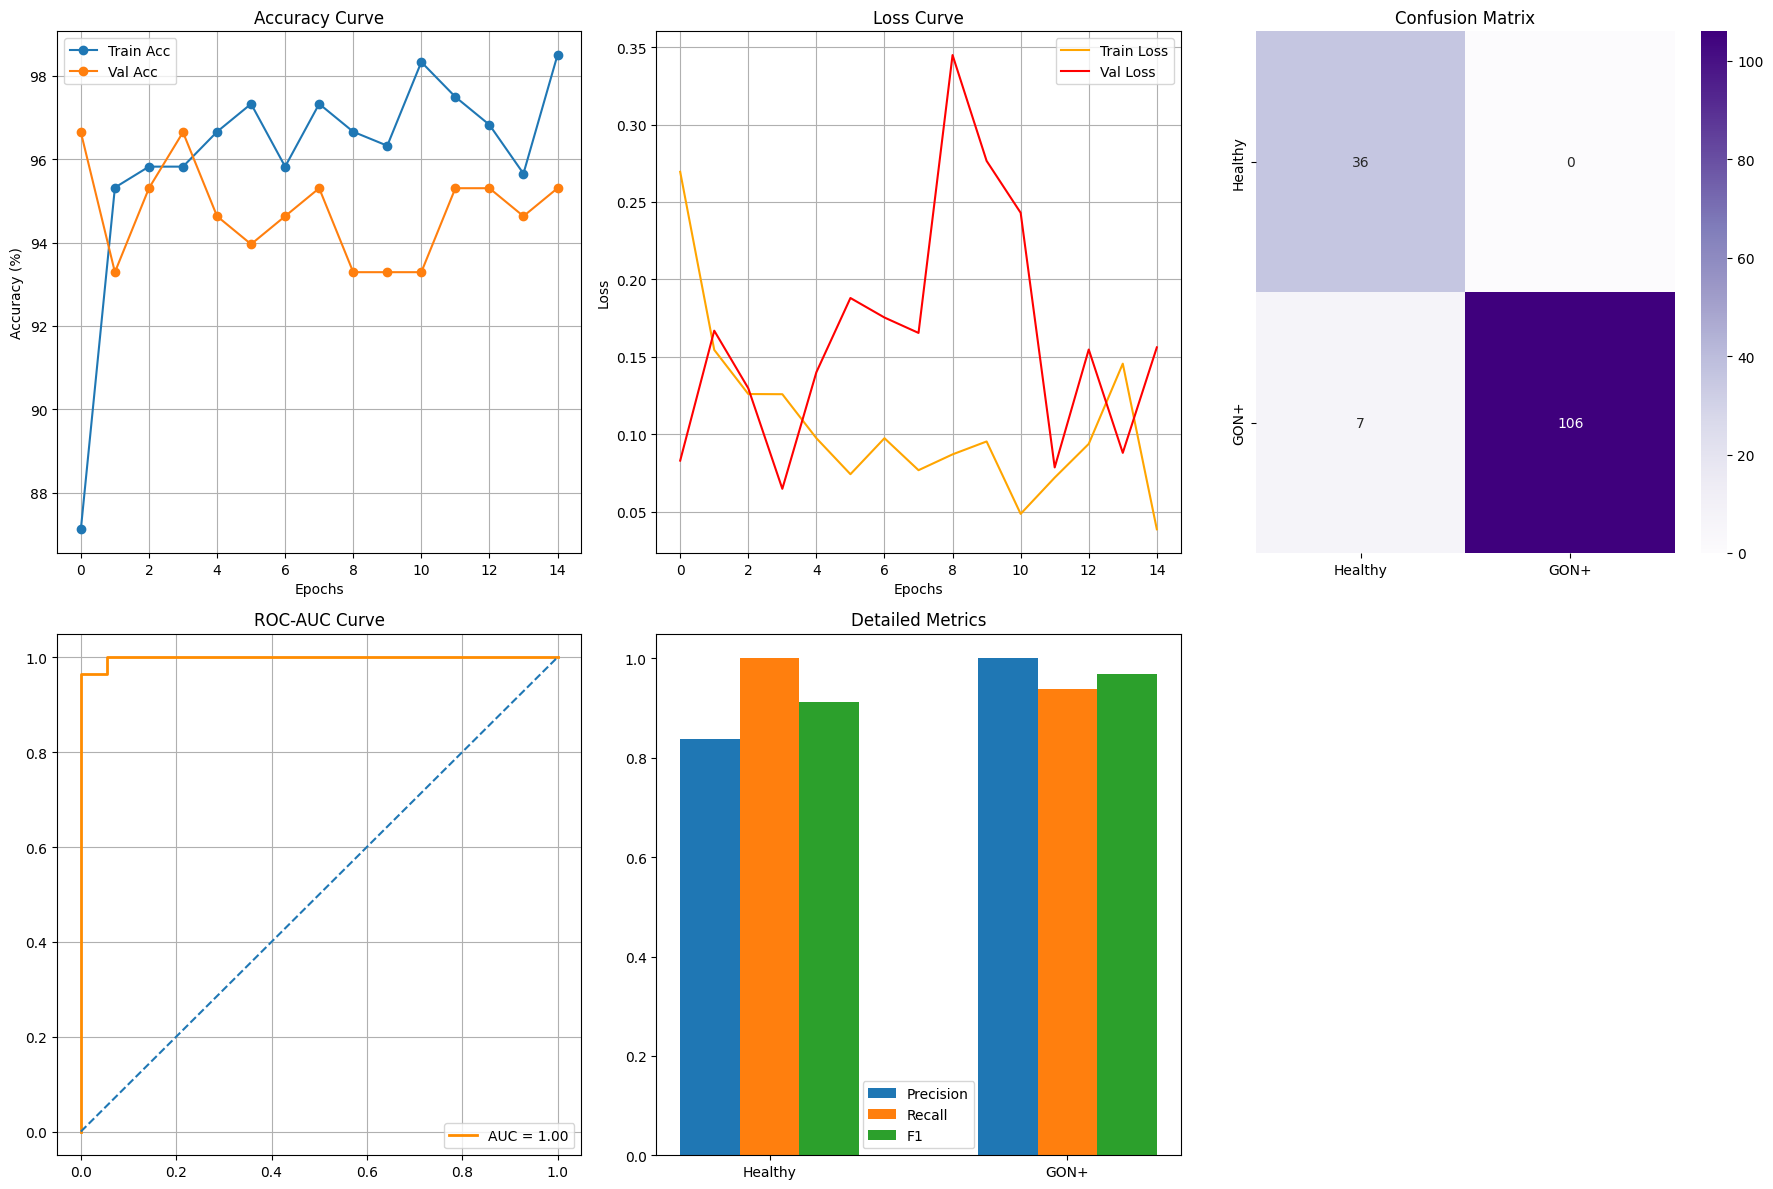


--- Visualizing Predictions on Test Images ---


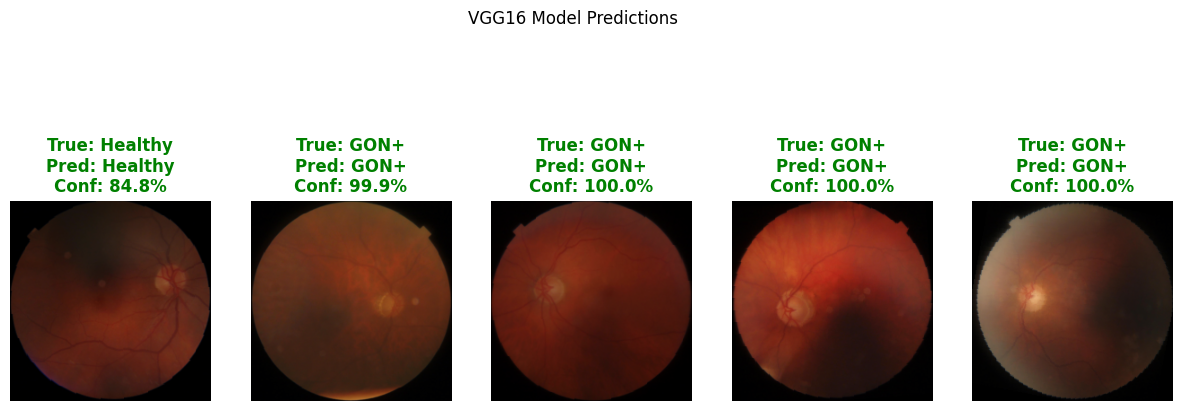

In [6]:
def show_full_report(history, model, loader, device):
    plt.figure(figsize=(18, 12))
    
    # 1. Accuracy Curve
    plt.subplot(2, 3, 1)
    plt.plot(history['train_acc'], label='Train Acc', marker='o')
    plt.plot(history['val_acc'], label='Val Acc', marker='o')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy (%)'); plt.legend(); plt.grid()
    
    # 2. Loss Curve
    plt.subplot(2, 3, 2)
    plt.plot(history['train_loss'], label='Train Loss', color='orange')
    plt.plot(history['val_loss'], label='Val Loss', color='red')
    plt.title('Loss Curve')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid()
    
    # Predictions
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_probs.extend(probs[:, 1].cpu().numpy())

    # 3. Confusion Matrix
    plt.subplot(2, 3, 3)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Healthy', 'GON+'], yticklabels=['Healthy', 'GON+'])
    plt.title('Confusion Matrix')
    
    # 4. ROC Curve
    plt.subplot(2, 3, 4)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title('ROC-AUC Curve'); plt.legend(); plt.grid()

    # 5. Precision-Recall Bars
    plt.subplot(2, 3, 5)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    x = np.arange(2)
    plt.bar(x - 0.2, precision, 0.2, label='Precision')
    plt.bar(x, recall, 0.2, label='Recall')
    plt.bar(x + 0.2, f1, 0.2, label='F1')
    plt.xticks(x, ['Healthy', 'GON+'])
    plt.title('Detailed Metrics'); plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # --- IMAGE PREDICTIONS ---
    print("\n--- Visualizing Predictions on Test Images ---")
    plt.figure(figsize=(15, 6))
    images, labels = next(iter(loader))
    images = images.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confs, preds = torch.max(probs, 1)
        
    for i in range(min(5, len(images))):
        ax = plt.subplot(1, 5, i+1)
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        
        col = 'green' if preds[i]==labels[i] else 'red'
        true_lab = "GON+" if labels[i]==1 else "Healthy"
        pred_lab = "GON+" if preds[i]==1 else "Healthy"
        
        plt.title(f"True: {true_lab}\nPred: {pred_lab}\nConf: {confs[i]*100:.1f}%", color=col, fontweight='bold')
        plt.axis('off')
    plt.suptitle("VGG16 Model Predictions")
    plt.show()

# Show Report for Augmented Model (Best One)
print("Generating Final VGG16 Report...")
show_full_report(history_aug, model_vgg_aug, test_loader_aug, device)

Cell 7: Save Best Model

In [7]:
save_path = os.path.join(DATASET_ROOT, 'vgg16_best_model.pth')
torch.save(model_vgg_aug.state_dict(), save_path)
print(f"VGG16 Best Model Saved at: {save_path}")

VGG16 Best Model Saved at: C:\Projects\Thesis-Fall-25-26--G-606-main\vgg16_best_model.pth


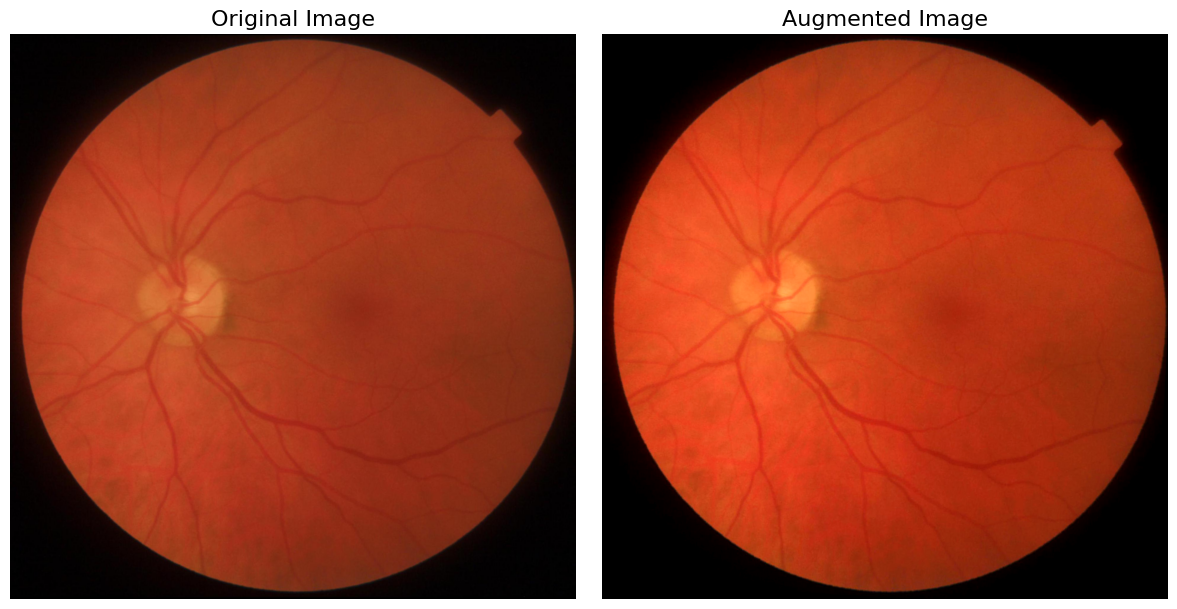

In [8]:
IMAGE_NAME = "87_2.jpg" # <--- CHANGE THIS to any image file name from your dataset

# Define the exact same augmentations used in your VGG16 notebook
# NOTE: We add ToPILImage() first because the augmentations expect a PIL image
augmentation_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])


# --- 2. Load the Original Image ---
image_path = os.path.join(DATASET_ROOT, "Images", IMAGE_NAME)

if not os.path.exists(image_path):
    print(f"ERROR: Image not found at {image_path}")
    print("Please make sure DATASET_ROOT and IMAGE_NAME are correct.")
else:
    # Load the original image using OpenCV
    original_image = cv2.imread(image_path)
    # Convert from BGR (OpenCV's default) to RGB for correct display
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)


    # --- 3. Apply the Augmentation ---
    augmented_tensor = augmentation_transforms(original_image_rgb)

    # Convert the augmented tensor back to a NumPy array for display
    # We need to change the order from (C, H, W) to (H, W, C) for matplotlib
    augmented_image = augmented_tensor.permute(1, 2, 0).numpy()


    # --- 4. Display the Images Side-by-Side ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display Original Image
    axes[0].imshow(original_image_rgb)
    axes[0].set_title("Original Image", fontsize=16)
    axes[0].axis('off') # Hide axes

    # Display Augmented Image
    axes[1].imshow(augmented_image)
    axes[1].set_title("Augmented Image", fontsize=16)
    axes[1].axis('off') # Hide axes

    plt.tight_layout()
    plt.show()


Generating predictions for confusion matrix...


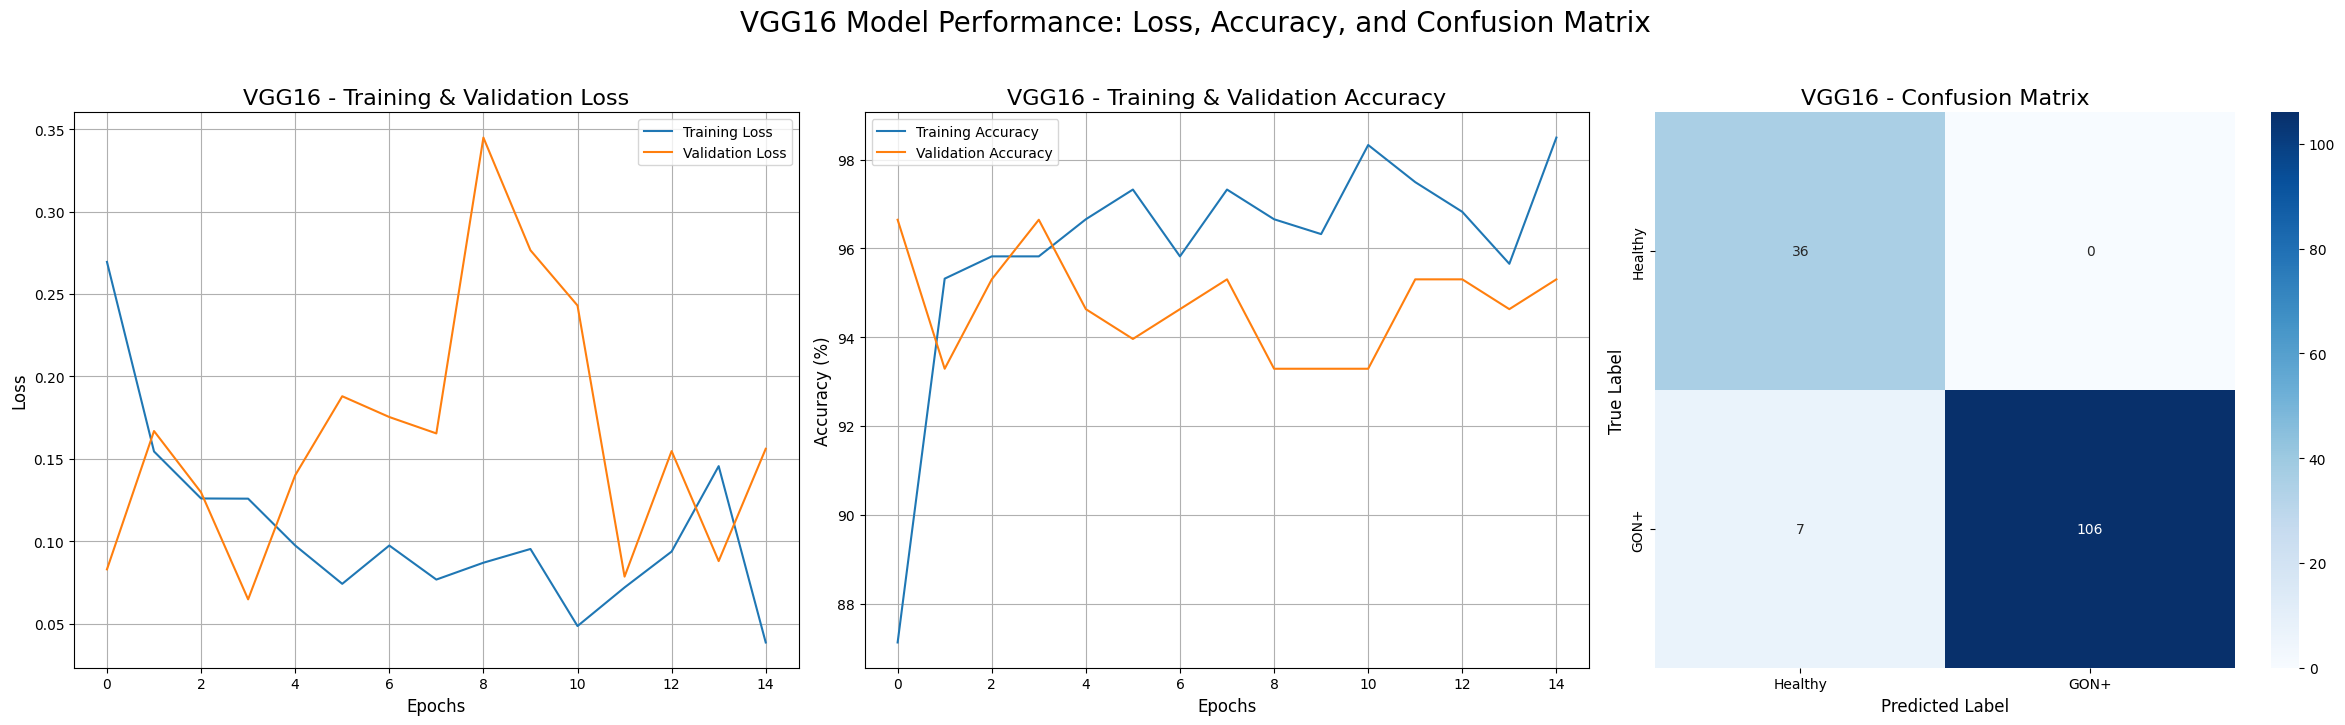


Final Test Accuracy: 95.30%


In [9]:
# This cell generates a combined graph for VGG16's performance.
# It uses the 'history_aug' from Cell 5 and generates predictions for the confusion matrix.

# Check if the necessary variables exist
if 'history_aug' not in locals() or 'model_vgg_aug' not in locals() or 'test_loader_aug' not in locals():
    print("Please run Cell 5 (the training cell) first to generate the results.")
else:
    # Generate predictions for confusion matrix
    print("Generating predictions for confusion matrix...")
    model_vgg_aug.eval()
    all_labels, all_preds = [], []
    
    with torch.no_grad():
        for images, labels in test_loader_aug:
            images, labels = images.to(device), labels.to(device)
            outputs = model_vgg_aug(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    
    # --- Plot 1: Training & Validation Loss ---
    axes[0].plot(history_aug['train_loss'], label='Training Loss')
    axes[0].plot(history_aug['val_loss'], label='Validation Loss')
    axes[0].set_title('VGG16 - Training & Validation Loss', fontsize=16)
    axes[0].set_xlabel('Epochs', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].legend()
    axes[0].grid(True)

    # --- Plot 2: Training & Validation Accuracy ---
    axes[1].plot(history_aug['train_acc'], label='Training Accuracy')
    axes[1].plot(history_aug['val_acc'], label='Validation Accuracy')
    axes[1].set_title('VGG16 - Training & Validation Accuracy', fontsize=16)
    axes[1].set_xlabel('Epochs', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].legend()
    axes[1].grid(True)

    # --- Plot 3: Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2],
                xticklabels=['Healthy', 'GON+'],
                yticklabels=['Healthy', 'GON+'])
    axes[2].set_title('VGG16 - Confusion Matrix', fontsize=16)
    axes[2].set_xlabel('Predicted Label', fontsize=12)
    axes[2].set_ylabel('True Label', fontsize=12)

    # Set an overall title for the figure
    fig.suptitle('VGG16 Model Performance: Loss, Accuracy, and Confusion Matrix', fontsize=20, y=1.03)
    
    plt.tight_layout()
    plt.show()
    
    # Print final accuracy
    final_accuracy = 100 * sum(1 for i, j in zip(all_labels, all_preds) if i == j) / len(all_labels)
    print(f"\nFinal Test Accuracy: {final_accuracy:.2f}%")
